# X - HEC Embeddings 2 : Advanced Word Representations

In this practical session, we will focus on word embeddings through word2vec and a simple classification model for sentiment analysis. Once a word2vec skipgram is trained, we can visualize learned word vectors in a reduced space and use them in our classification model.

In [1]:
import io
import os
import re
import warnings
import itertools

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from ast import literal_eval

import tensorflow as tf
import tensorflow_datasets as tfds

from tqdm import tqdm_notebook
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')

# Load Data

In [2]:
# Define data path
file_path = os.getcwd() + '/clean_full_graph.csv.gzip'

# Read csv file with right parameters
df_all = pd.read_csv(file_path, 
                     compression='gzip', 
                     low_memory=False, 
                     parse_dates=['review_date', 'review_date_diner'])

df_all.head(2)

,review_id,review_date,review_date_diner,review_has_answer,review_rating,review_rating_value,review_rating_service,review_rating_atmosphere,review_rating_food,review_title,...,rest_rating_excellent,rest_rating_very_good,rest_rating_neutral,rest_rating_poor,rest_rating_terrible,rest_url,rest_url_menu,rest_adress,rest_description,grp
0,g191301-d4453079-r728219948,2019-11-22,2019-11-01,True,4.5,NaN,NaN,NaN,NaN,Birthday Shots shots shots!,...,833,101,43.0,34.0,65.0,https://www.tripadvisor.com/ShowUserReviews-g1...,http://www.revolution-bars.co.uk/bar/london-ri...,4 Whittaker Avenue,"Perched on the Thames riverside, this beautifu...",cap
1,g191301-d4453079-r728632295,2019-11-24,2019-11-01,True,4.5,NaN,NaN,NaN,NaN,Louis!!!,...,833,101,43.0,34.0,65.0,https://www.tripadvisor.com/ShowUserReviews-g1...,http://www.revolution-bars.co.uk/bar/london-ri...,4 Whittaker Avenue,"Perched on the Thames riverside, this beautifu...",cap


For the current exercice we'll work with Capgemini Invent's dataset, so that everyone has the same data. Later on you could try to do your own embedding with your scrapped data and compare the results.

In [3]:
df_cap = df_all[df_all.grp == 'cap'].reset_index(drop=True)
df_cap.head(2)

,review_id,review_date,review_date_diner,review_has_answer,review_rating,review_rating_value,review_rating_service,review_rating_atmosphere,review_rating_food,review_title,...,rest_rating_excellent,rest_rating_very_good,rest_rating_neutral,rest_rating_poor,rest_rating_terrible,rest_url,rest_url_menu,rest_adress,rest_description,grp
0,g191301-d4453079-r728219948,2019-11-22,2019-11-01,True,4.5,NaN,NaN,NaN,NaN,Birthday Shots shots shots!,...,833,101,43.0,34.0,65.0,https://www.tripadvisor.com/ShowUserReviews-g1...,http://www.revolution-bars.co.uk/bar/london-ri...,4 Whittaker Avenue,"Perched on the Thames riverside, this beautifu...",cap
1,g191301-d4453079-r728632295,2019-11-24,2019-11-01,True,4.5,NaN,NaN,NaN,NaN,Louis!!!,...,833,101,43.0,34.0,65.0,https://www.tripadvisor.com/ShowUserReviews-g1...,http://www.revolution-bars.co.uk/bar/london-ri...,4 Whittaker Avenue,"Perched on the Thames riverside, this beautifu...",cap


In [4]:
df_cap = df_cap[df_cap['review_content'].str.len() >= 4]

# Tokenization & Text Encoding
This part concerns tokenization and text encoding with TensorFlow modules :

*(i) Build the token vocabulary* <br>
*(ii) Build a text encoder relying each word to an index, and thus each text to a sequence of word indices* (```list```) <br>
*(iii) Build a TensorFlow dataset for word2vec training*


1. **Tokenization** : Build Vocabulary

In [5]:
DATASET_SIZE = 10000

df_cap['review_content'] = df_cap['review_content'].apply(lambda x : literal_eval(x)[0])

reviews = df_cap['review_content'][:DATASET_SIZE].values.tolist()
tokenizer = tfds.features.text.Tokenizer()
vocabulary_set = set()

for text in tqdm_notebook(reviews) :
    
    tokens = tokenizer.tokenize(text)
    vocabulary_set.update(tokens)
    
vocab_size = len(vocabulary_set)
vocab_size

18557

2. **Token Encoding**

In [6]:
token_encoder = tfds.features.text.TokenTextEncoder(vocabulary_set)

print(df_cap['review_content'][0])

print('\n')

token_encoded_text = token_encoder.encode(df_cap['review_content'][0])
print(token_encoded_text)

print('\n')

token_decoded_text = token_encoder.decode(token_encoded_text)
print(token_decoded_text)

The atmosphere in here is great, we came for birthday drinks and never left, music is on point too, it’s fun and lively. Lewis was super friendly and helpful serving us and even suggested some great tasting shots! Ask for Lewis when you visit!!


[13517, 5874, 11954, 5199, 4314, 4497, 13095, 7796, 16995, 10409, 13815, 6501, 16411, 10545, 16753, 4314, 7224, 2564, 5761, 10737, 2058, 7635, 6501, 1895, 16029, 15581, 14484, 14347, 6501, 3187, 14535, 5381, 6501, 1547, 14213, 16737, 4497, 10216, 14117, 17670, 16995, 16029, 15819, 16475, 9065]


The atmosphere in here is great we came for birthday drinks and never left music is on point too it s fun and lively Lewis was super friendly and helpful serving us and even suggested some great tasting shots Ask for Lewis when you visit


In [7]:
for tk in token_encoded_text[:10] :
    
    print('{} ----> {}'.format(tk, token_encoder.decode([tk])))

13517 ----> The
5874 ----> atmosphere
11954 ----> in
5199 ----> here
4314 ----> is
4497 ----> great
13095 ----> we
7796 ----> came
16995 ----> for
10409 ----> birthday


3. **Build Learning Dataset**

To learn word2vec vectors, we define center and context words. Thus, we concatenate each document, i.e. sequence of word indices to make the moving context window possible.

*Question : build this corpus of concatenated encoded documents, i.e. transform a list of* ```DATASET_SIZE``` *lists of indices in one list.*

In [8]:
 #### FILL THE BLANK(S) ####
all_tokens = []
for review in reviews:
    all_tokens += token_encoder.encode(review)
len(all_tokens)

583157

The ```tf.keras.preprocessing.sequence.make_sampling_table``` and ```tf.keras.preprocessing.sequence.skipgrams``` sequence preprocessing functions are useful to build the negative sampled dataset. The ```skipgrams```function allows to browse the entire document (```all_tokens```) to identify positive and negative pairs of center and context words.

*Question : use these functions to get skipgram word pairs with labels (positive or negative). You can use the default* ```sampling_factor```, ```window_size```=4 *and generate one* ```negative_samples```.

In [9]:
#### FILL THE BLANK(S) ####

sampling_table = tf.keras.preprocessing.sequence.make_sampling_table(vocab_size + 1, sampling_factor=1e-05)

#### FILL THE BLANK(S) ####
X, y = tf.keras.preprocessing.sequence.skipgrams(
    all_tokens, vocab_size + 1, window_size=4, negative_samples=1.0, shuffle=True,
    categorical=False, sampling_table=sampling_table, seed=42
)

For word2vec training, we won't use a validation dataset this time. In eventual further experimentations, you could include it !

In [10]:
BUFFER_SIZE = len(X)
BATCH_SIZE = 2048

# threshold_set = int(np.floor(0.8*len(X)))
# 
# X_train, y_train = tf.convert_to_tensor(X[:threshold_set], dtype=tf.int32), tf.convert_to_tensor(y[:threshold_set], dtype=tf.int32)
# center_words_train, context_words_train = X_train[:,0], X_train[:,1]
# 
# word2vec_dataset_train = tf.data.Dataset.from_tensor_slices((center_words_train, context_words_train, y_train)).batch(BATCH_SIZE)
# 
# X_test, y_test = tf.convert_to_tensor(X[threshold_set:], dtype=tf.int32), tf.convert_to_tensor(y[threshold_set:], dtype=tf.int32)
# center_words_test, context_words_test = X_test[:,0], X_test[:,1]
# 
# word2vec_dataset_test = tf.data.Dataset.from_tensor_slices((center_words_test, context_words_test, y_test)).batch(BATCH_SIZE)

X, y = tf.convert_to_tensor(X, dtype=tf.int32), tf.convert_to_tensor(y, dtype=tf.int32)
center_words, context_words = X[:,0], X[:,1]

word2vec_dataset = tf.data.Dataset.from_tensor_slices((center_words, context_words, y)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Word2vec SkipGram with Negative Sampling

In [11]:
center_words_batch, context_words_batch, y_batch = next(iter(word2vec_dataset))
print(center_words_batch.shape, context_words_batch.shape, y_batch.shape, sep='\n')

(2048,)
(2048,)
(2048,)


1. **SkipGram Model**

In [12]:
class SkipGram(tf.keras.Model):
    
    def __init__(self, d_model, token_vocab_size):
        
        super(SkipGram, self).__init__()
        
        self.d_model = d_model
        self.vocab_size = token_vocab_size
        
        self.input_embedding = tf.keras.layers.Embedding(self.vocab_size, self.d_model, name='input_embedding')
        self.output_embedding = tf.keras.layers.Embedding(self.vocab_size, self.d_model, name='output_embedding')
        
        
    def call(self, center_word, context_word):
        
        center_vector = self.input_embedding(center_word)
        context_vector = self.output_embedding(context_word)
        
        dot_product = tf.math.reduce_sum(tf.multiply(center_vector, context_vector), axis=1)
        
        return tf.math.sigmoid(dot_product) # loss : from_logits=False

In [13]:
skipgram = SkipGram(300, token_encoder.vocab_size)
assert skipgram(center_words_batch, context_words_batch).shape[0] == BATCH_SIZE

2. **Optimization Objective**

In [14]:
loss_object = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam()

In [15]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.BinaryAccuracy(name='train_accuracy')

# test_loss = tf.keras.metrics.Mean(name='test_loss')
# test_accuracy = tf.keras.metrics.BinaryAccuracy(name='test_accuracy')

3. **Training Loop**

In [16]:
def train_step(center_word, context_word, label):
    
    with tf.GradientTape() as tape :
        
        prediction = skipgram(center_word, context_word)
        loss = loss_object(label, prediction)
    
    gradient = tape.gradient(loss, skipgram.trainable_variables)
    optimizer.apply_gradients(zip(gradient, skipgram.trainable_variables))

    train_loss(loss)
    train_accuracy(label, prediction)

In [17]:
# def test_step(center_word, context_word, label):
#     
#     prediction = skipgram(center_word, context_word)
#     loss = loss_object(label, prediction)
# 
#     test_loss(loss)
#     test_accuracy(label, prediction)

One epoch can take almost 10 minutes so define a small number of epochs to end the hands on !

In [18]:

#### FILL THE BLANK(S) ####
EPOCHS = 2

DATASET_LENGTH = X.shape[0] # threshold_set


for epoch in tqdm_notebook(iterable = range(EPOCHS), total = EPOCHS, desc = 'T R A I N I N G') :
    
    train_loss.reset_states()
    train_accuracy.reset_states()
    # test_loss.reset_states()
    # test_accuracy.reset_states()
    
    for center_word, context_word, label in tqdm_notebook(word2vec_dataset, 
                                                          total = int(np.ceil(DATASET_LENGTH/BATCH_SIZE)), 
                                                          desc = 'Epoch {}/{}'.format(epoch+1, EPOCHS)) : 
        
        train_step(center_word, context_word, label)
    
    
    # for center_word, context_word, label in word2vec_dataset_test :
    #     
    #     test_step(center_word, context_word, label)
    

    print ('Loss : {} - Accuracy : {}\n'.format(train_loss.result(), 
                                                train_accuracy.result()*100))


Loss : 0.28221145272254944 - Accuracy : 89.20976257324219




Loss : 0.2374938726425171 - Accuracy : 90.74012756347656




In [19]:
#skipgram.save_weights("'./checkpoints/skipgram")

# Embedding Visualization

In [20]:
skipgram.summary()

Model: "skip_gram"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_embedding (Embedding)  multiple                  5567700   
_________________________________________________________________
output_embedding (Embedding) multiple                  5567700   
Total params: 11,135,400
Trainable params: 11,135,400
Non-trainable params: 0
_________________________________________________________________


*Questions : get the weights of the* ```input_embedding``` *layer and store them in a variable* ```weights```. *These weights correspond to word2vec skipgram embeddings.*

In [31]:
weights = skipgram.get_layer('input_embedding').weights[0]

print(weights, weights.shape, sep='\n')

<tf.Variable 'skip_gram/input_embedding/embeddings:0' shape=(18559, 300) dtype=float32, numpy=
array([[-0.00345839, -0.01120815,  0.02518672, ...,  0.00384615,
         0.01905317, -0.00104453],
       [ 0.11627228,  0.04737414, -0.15835571, ...,  0.10431334,
         0.20495827,  0.24359071],
       [-0.03155494,  0.04383508,  0.03144047, ..., -0.04260769,
         0.04029587, -0.02038935],
       ...,
       [ 0.13590938, -0.23584588, -0.04178676, ...,  0.18079436,
         0.13327236,  0.1452022 ],
       [ 0.19993116, -0.10609153, -0.12933359, ...,  0.16039568,
         0.19158788,  0.14578694],
       [-0.02138576,  0.03639597,  0.00296988, ...,  0.0159304 ,
        -0.00859344,  0.02970768]], dtype=float32)>
(18559, 300)


*Question : use the following cell to store the learned vectors in the correct format and visualize them in the Embedding Projector.*

In [32]:
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

for idx, word in enumerate(token_encoder.tokens):
    
    vec = weights[idx+1] # skip 0, it's padding.
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in vec]) + "\n")
    
out_v.close()
out_m.close()

In [147]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)
word2vec_2D = tsne.fit_transform(weights.numpy()[1:-1])

In [154]:
import random
indices = list(range(len(token_encoder.tokens)))
selected_indices = random.sample(indices, 100)

Text(0.5, 1.0, 't-SNE Words in Embedded space')

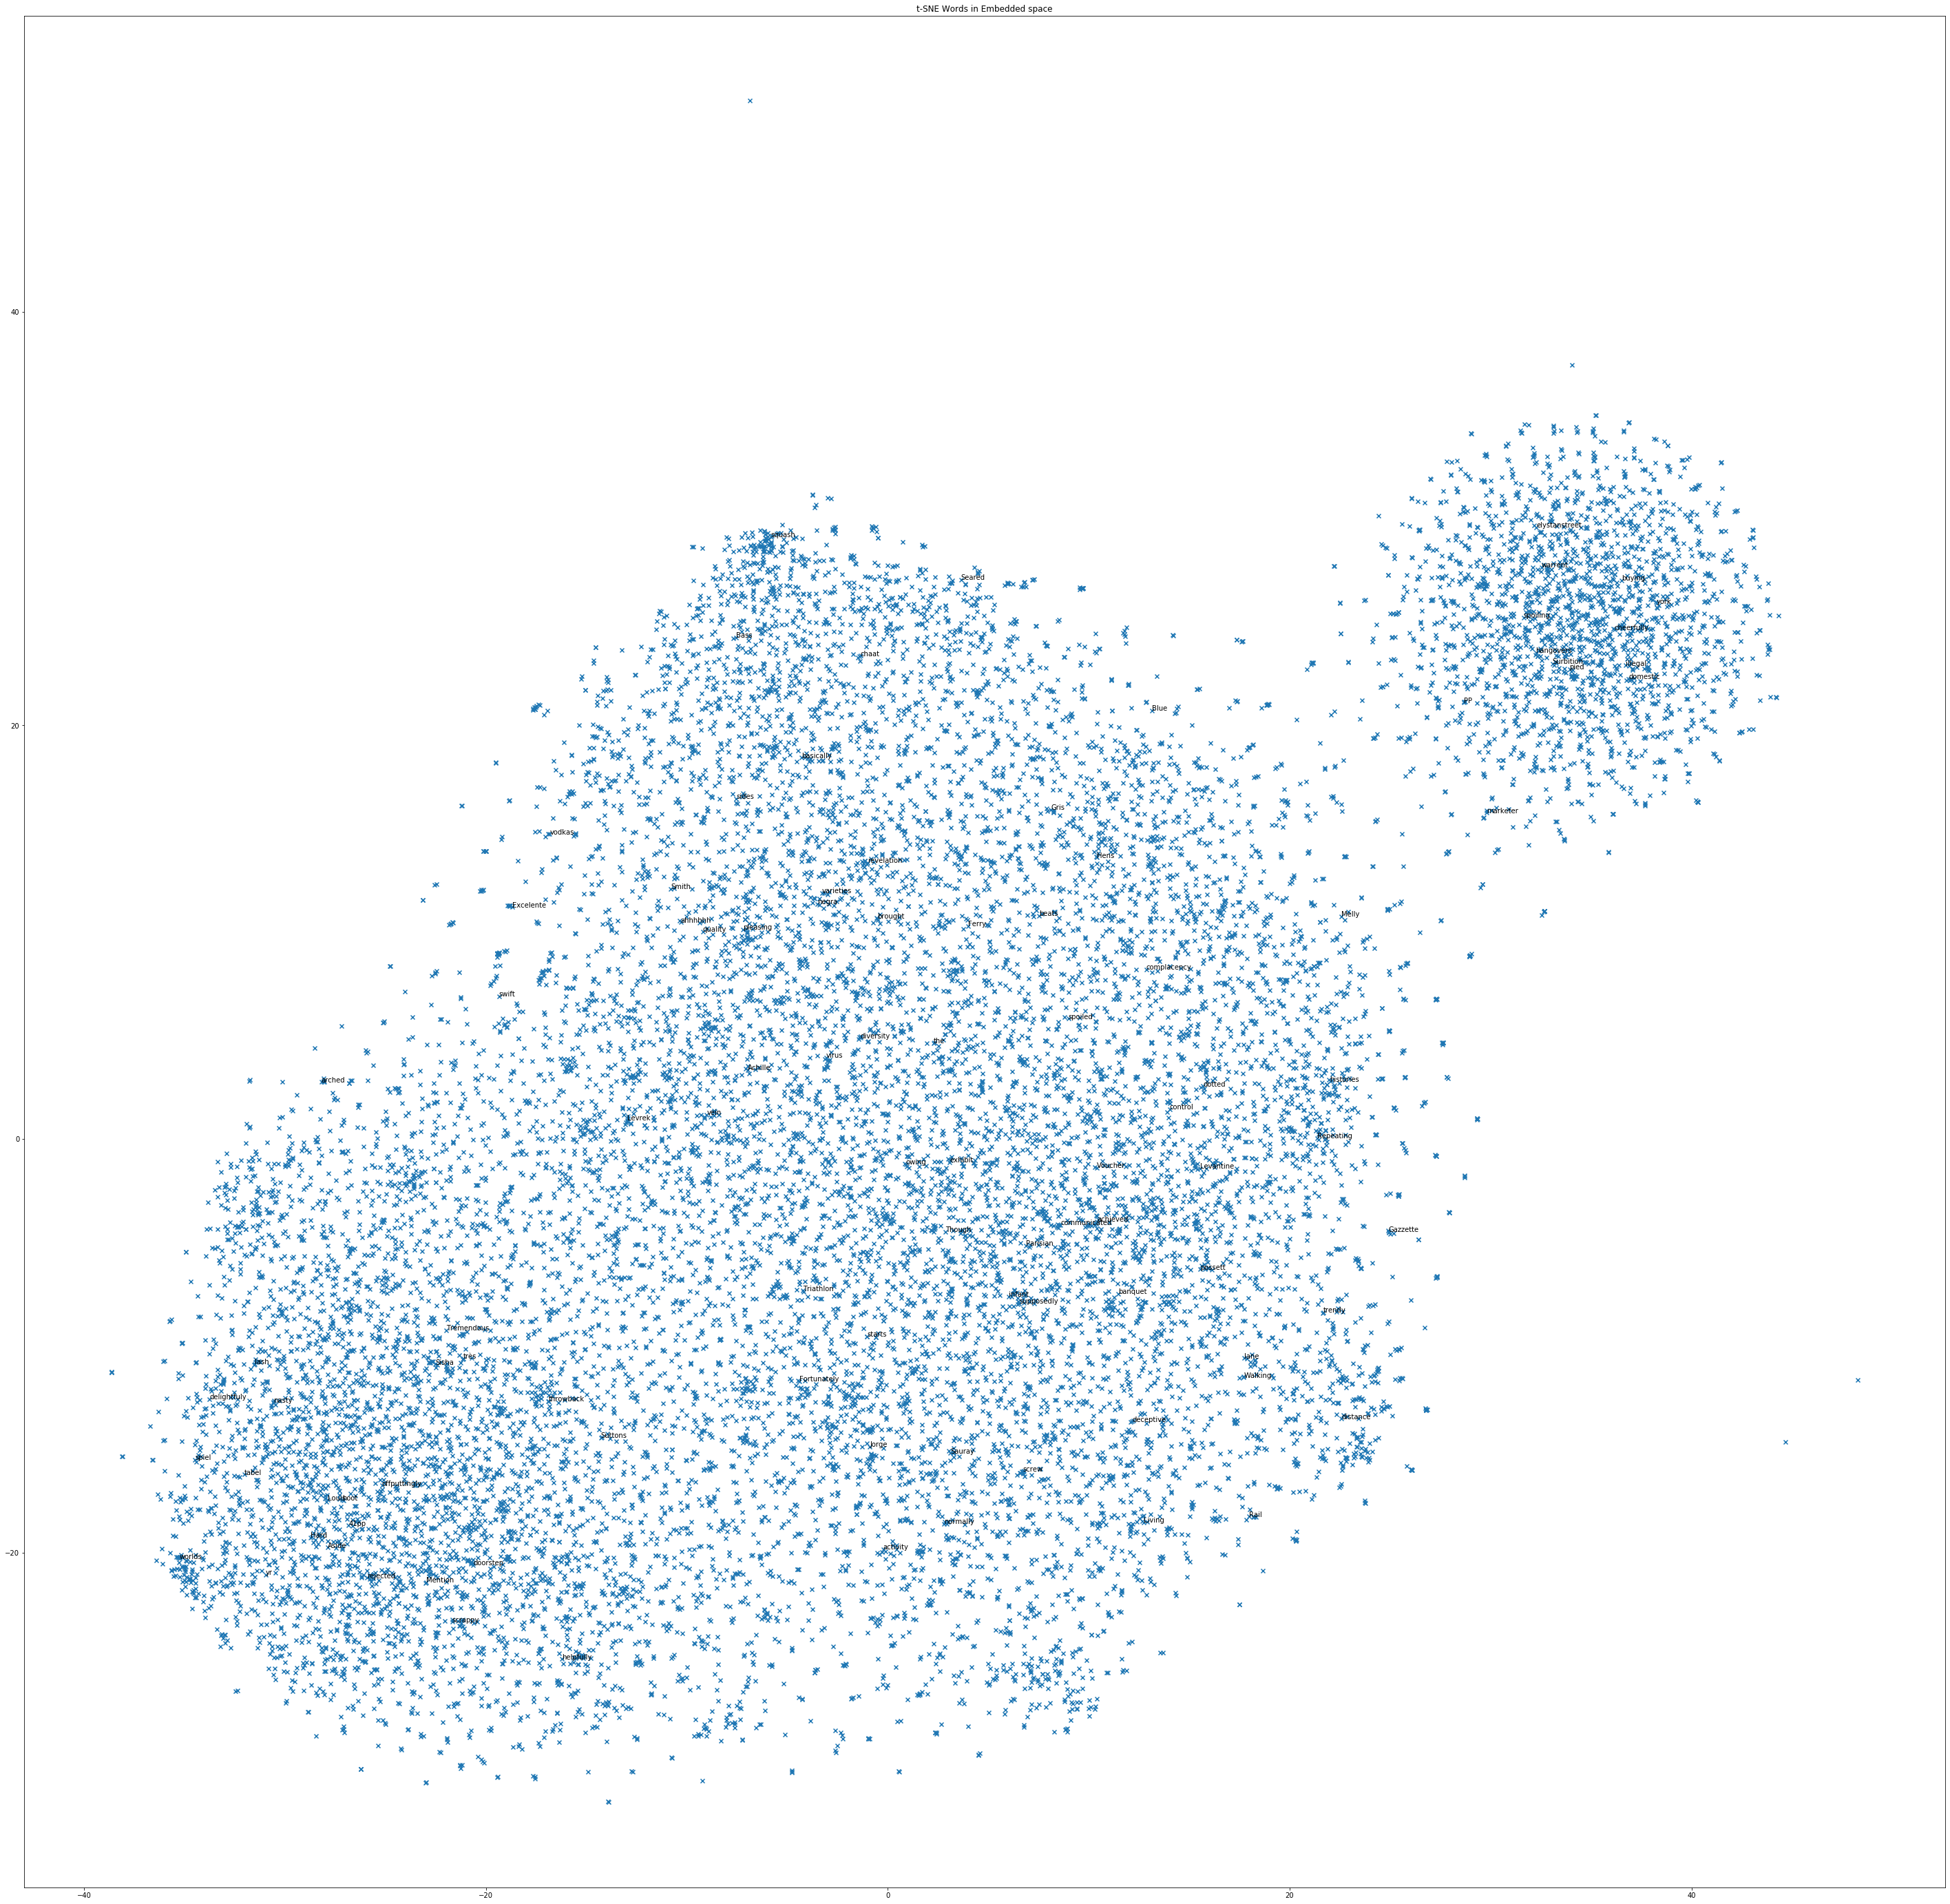

In [156]:
fig = plt.figure(figsize=(50,50))
plt.scatter(x = word2vec_2D[:,0], y = word2vec_2D[:,1], marker='x')
for i in selected_indices:
    pass
    plt.annotate(token_encoder.tokens[i], (word2vec_2D[i,0], word2vec_2D[i,1]))
plt.title('t-SNE Words in Embedded space')

To visualize your trained embeddings, open the [Embedding Projector](http://projector.tensorflow.org/) :

- Click on "Load data".
- Upload the two files we created above : vecs.tsv and meta.tsv.

The embeddings will now be displayed. You can search for words from ```token_encoder.tokens``` to find their closest neighbors.

# Text Classication : Sentiment Analysis
Our learned word embeddings can be used to represent the words of a text and to build a text representation. This text representation will be useful for classifcation.

*Question : in this part, our objective is to train a text classification model for sentiment analysis using the first* ```DATASET_SIZE``` reviews*. You have to :*
1. *Build the learning dataset : use the ```review_content``` column for text inputs and ```rest_rating``` for sentiments (outputs).* **NB** *: Don't forget to encode and pad your text, and use one-hot encoding for sentiment labels.*
2. *Once the learning dataset built, you have to split it into train and validation datasets.*
3. *Define and train a text classification model.*

As indications, you can use ```tf.keras.preprocessing.sequence.pad_sequences``` for text padding and ```tf.keras.utils.to_categorical``` for one-hot label encoding. For your first model, you can already use the simple text classification model described in the course with ```tf.keras.Sequential``` API :
1. An embedding layer : if you use zero padding, you can set ```mask_zero=True``` and use the ```weights``` matrix for initialization.
2. A dense layer without particular activation function for linear projection of the previous embedding vectors.
3. A global average pooling (1D).
4. A final dense layer for linear projection in a $d$-dimensional space for sentiment prediction, with $d$ the number of possible sentiments/classes.


## Prepare X

In [36]:
# Tokenize reviews and feed into nested list[review, word]
tokenized_reviews = []
tokenized_review_length = []
for review in reviews:
    tk_review = token_encoder.encode(review)
    tokenized_reviews.append(tk_review)
    tokenized_review_length.append(len(tk_review))

In [49]:
# Number of words contained after padding sequence: twice the average length of reviews
print(np.mean(tokenized_review_length))
max_words = 120

58.3157


In [50]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
X_train_TKP = pad_sequences(tokenized_reviews, maxlen=max_words)
print(X_train_TKP.shape)

(10000, 120)


## Prepare Y

In [55]:
# ratings: 5 classes [3.0, 3.5, 4.0, 4.5, 5.0]
df_cap['review_rating'][:DATASET_SIZE].unique()

array([4.5, 5. , 4. , 3.5, 3. ])

In [59]:
ratings = np.array(df_cap['review_rating'][:DATASET_SIZE].values.tolist())

In [60]:
Y_train = tf.keras.utils.to_categorical((ratings * 2 - 6), num_classes=5)

In [63]:
print(Y_train.shape)

(10000, 5)


## MODEL

### <font color='red'>* Both models suffer from overfitting</font> 

In [110]:
sentiment_model_ANN = tf.keras.Sequential()
sentiment_model_ANN.add(tf.keras.layers.Embedding(token_encoder.vocab_size, 300, input_shape=(max_words,), mask_zero=True, 
                                                  weights=skipgram.get_layer('input_embedding').get_weights(), 
                                                  trainable=True, name='EMB_INIT'))

sentiment_model_ANN.add(tf.keras.layers.Dense(256, name='FC1'))

sentiment_model_ANN.add(tf.keras.layers.GlobalAveragePooling1D(data_format='channels_last', name='GAP1D'))

sentiment_model_ANN.add(tf.keras.layers.Dense(256, input_shape=(64,), name='FC2'))

sentiment_model_ANN.add(tf.keras.layers.Dense(5, name='OUT'))

sentiment_model_ANN.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                        optimizer=tf.keras.optimizers.Adam(1e-3),
                        metrics=['accuracy'])

sentiment_model_ANN.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
EMB_INIT (Embedding)         (None, 120, 300)          5567700   
_________________________________________________________________
FC1 (Dense)                  (None, 120, 256)          77056     
_________________________________________________________________
GAP1D (GlobalAveragePooling1 (None, 256)               0         
_________________________________________________________________
FC2 (Dense)                  (None, 256)               65792     
_________________________________________________________________
OUT (Dense)                  (None, 5)                 1285      
Total params: 5,711,833
Trainable params: 5,711,833
Non-trainable params: 0
_________________________________________________________________


In [111]:
sentiment_model_ANN.fit(X_train_TKP, Y_train, validation_split=0.2, epochs=10, batch_size=128, verbose=1)

Train on 8000 samples, validate on 2000 samples
Epoch 1/10
8000/8000 [==============================] - 8s 995us/sample - loss: 1.0919 - accuracy: 0.5065 - val_loss: 1.0788 - val_accuracy: 0.6150
Epoch 2/10
8000/8000 [==============================] - 8s 943us/sample - loss: 0.9789 - accuracy: 0.5617 - val_loss: 1.0193 - val_accuracy: 0.6270
Epoch 3/10
8000/8000 [==============================] - 7s 894us/sample - loss: 0.7880 - accuracy: 0.6749 - val_loss: 1.0389 - val_accuracy: 0.6430
Epoch 4/10
8000/8000 [==============================] - 8s 944us/sample - loss: 0.5697 - accuracy: 0.7800 - val_loss: 1.1778 - val_accuracy: 0.6285
Epoch 5/10
8000/8000 [==============================] - 8s 952us/sample - loss: 0.3982 - accuracy: 0.8577 - val_loss: 1.6034 - val_accuracy: 0.5270
Epoch 6/10
8000/8000 [==============================] - 7s 902us/sample - loss: 0.2747 - accuracy: 0.9057 - val_loss: 1.8950 - val_accuracy: 0.5430
Epoch 7/10
8000/8000 [==============================] - 7s 919us

### We tried a LSTM model here, but still overfitted

In [91]:
from tensorflow.keras.layers import Dense, Flatten, Activation, Embedding
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, Conv1D, LSTM, Bidirectional, Reshape

sentiment_model_LSTM = tf.keras.Sequential()
sentiment_model_LSTM.add(tf.keras.layers.Embedding(token_encoder.vocab_size, 300, input_shape=(max_words,), mask_zero=True, 
                                                  weights=skipgram.get_layer('input_embedding').get_weights(), 
                                                  trainable=True, name='EMB_INIT'))

sentiment_model_LSTM.add(LSTM(256, return_sequences=True, name="LSTM1"))

sentiment_model_LSTM.add(LSTM(128, return_sequences=False, name="LSTM2"))

sentiment_model_LSTM.add(tf.keras.layers.Dense(5, activation='softmax', name='OUT'))

sentiment_model_LSTM.compile(loss='categorical_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy'])

sentiment_model_LSTM.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
EMB_INIT (Embedding)         (None, 120, 300)          5567700   
_________________________________________________________________
LSTM1 (LSTM)                 (None, 120, 256)          570368    
_________________________________________________________________
LSTM2 (LSTM)                 (None, 128)               197120    
_________________________________________________________________
OUT (Dense)                  (None, 5)                 645       
Total params: 6,335,833
Trainable params: 6,335,833
Non-trainable params: 0
_________________________________________________________________


In [92]:
sentiment_model_LSTM.fit(X_train_TKP, Y_train, validation_split=0.2, epochs=10, batch_size=128, verbose=1)

Train on 8000 samples, validate on 2000 samples
Epoch 1/10
8000/8000 [==============================] - 72s 9ms/sample - loss: 1.1143 - accuracy: 0.4933 - val_loss: 1.1215 - val_accuracy: 0.6265
Epoch 2/10
8000/8000 [==============================] - 63s 8ms/sample - loss: 1.0845 - accuracy: 0.5052 - val_loss: 1.1281 - val_accuracy: 0.6265
Epoch 3/10
8000/8000 [==============================] - 65s 8ms/sample - loss: 1.0454 - accuracy: 0.5197 - val_loss: 1.0992 - val_accuracy: 0.5840
Epoch 4/10
8000/8000 [==============================] - 62s 8ms/sample - loss: 0.8912 - accuracy: 0.6135 - val_loss: 1.0422 - val_accuracy: 0.6125
Epoch 5/10
8000/8000 [==============================] - 62s 8ms/sample - loss: 0.6864 - accuracy: 0.7253 - val_loss: 1.1045 - val_accuracy: 0.5985
Epoch 6/10
8000/8000 [==============================] - 62s 8ms/sample - loss: 0.4712 - accuracy: 0.8199 - val_loss: 1.4094 - val_accuracy: 0.5565
Epoch 7/10
8000/8000 [==============================] - 62s 8ms/sample

# Improve your sentiment model coupling reviewer embeddings and word embeddigns

<img src="classif.png"></img>

#### Reviewer classification model 
Create a second sentiment model that will solely use the reviewer embeddings to predict the restaurant rating

#### Data preparation

In [93]:
from gensim.models import Word2Vec
n2v = Word2Vec.load("node2vec.pkl")

In [94]:
labeled_documents = df_cap[['review_content', 'rest_rating', 'reviewer_pseudo']].head(DATASET_SIZE).dropna().reset_index(drop=True)
labeled_documents.shape

(10000, 3)

In [119]:
labeled_documents

,review_content,rest_rating,reviewer_pseudo
0,"The atmosphere in here is great, we came for b...",4.5,Chris B
1,"Came in for a few drinks with some friends, Lo...",4.5,Matt L
2,"So many 1st timer reviews, all mentioning staf...",4.5,montySurrey
3,Very great bar and service! The staff were ver...,4.5,Sam S
4,Revolution is quite a large pub chain selling ...,4.5,futtock21
...,...,...,...
9995,Have not been for a little while but have alwa...,4.0,John H
9996,Excellent place for lunch or dinner and escpec...,4.0,Paul A
9997,We had the festive menu. Good value as include...,4.0,Christine M
9998,Had lunch on a Tuesday in this restaurant. Ver...,4.0,dumid


### Build X_train2 (reviewer embeddings size=(64,))

In [118]:
X_train2 = np.zeros([DATASET_SIZE, 64])
OOV_count = 0
for i in range(DATASET_SIZE):
    try:
        X_train2[i,:] = n2v[labeled_documents.iloc[i,2]]
    except:
        OOV_count += 1
print("OOV Reviewers: ", OOV_count, "/10000")

OOV Reviewers:  2928 /10000


In [124]:
print(X_train2.shape)

(10000, 64)


1. Create a second sentiment model that will solely use the reviewer embeddings to predict the sentiment
2. Merge the first and two models to complete the above architecture. 


You will be using the functional API of keras. 

#### Proposed architecture 
**Review NLP model**  
1. Input Shape : the input text sequence of max size N (including padding)
2. Embedding Layers: mapping the embedding matrix with your input sequence
3. Dense layer: linear projection of the previous embedding
3. Global average Pooling 1D: 
4. Flatten: just flattening the representation into a vector, this is the review embedding ! 

**Reviewer (meta features) model**
5. Input Shape : the input reviewer embedding of size N' (dimension you choose for node2vec)


**Merging the two models**
6. Concatenate layer merging the two models input. 
7. Global average Pooling 1D: 
8. Flatten: Final representation before classification
9. Dense layer with softmax activation of size corresponding to the number of class


In [131]:
sentiment_model2 = tf.keras.Sequential([
    tf.keras.layers.Dense(400, input_shape=(64,)),
    tf.keras.layers.Dense(5)
])

sentiment_model2.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                        optimizer=tf.keras.optimizers.Adam(1e-4),
                        metrics=['accuracy'])

In [132]:
history = sentiment_model2.fit(
    X_train2, Y_train, epochs=10, validation_split=0.2, verbose=1)

Train on 8000 samples, validate on 2000 samples
Epoch 1/10
8000/8000 [==============================] - 7s 917us/sample - loss: 1.6302 - accuracy: 0.3716 - val_loss: 1.3727 - val_accuracy: 0.4965
Epoch 2/10
8000/8000 [==============================] - 1s 156us/sample - loss: 1.3005 - accuracy: 0.4796 - val_loss: 1.1808 - val_accuracy: 0.5910
Epoch 3/10
8000/8000 [==============================] - 1s 164us/sample - loss: 1.1944 - accuracy: 0.4980 - val_loss: 1.0927 - val_accuracy: 0.6215
Epoch 4/10
8000/8000 [==============================] - 2s 231us/sample - loss: 1.1393 - accuracy: 0.5019 - val_loss: 1.0515 - val_accuracy: 0.6105
Epoch 5/10
8000/8000 [==============================] - 1s 151us/sample - loss: 1.1089 - accuracy: 0.5038 - val_loss: 1.0333 - val_accuracy: 0.6120
Epoch 6/10
8000/8000 [==============================] - 1s 156us/sample - loss: 1.0933 - accuracy: 0.5029 - val_loss: 1.0161 - val_accuracy: 0.6105
Epoch 7/10
8000/8000 [==============================] - 1s 152us

In [134]:
sentiment_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(token_encoder.vocab_size, 300, mask_zero=True, weights=skipgram.get_layer('input_embedding').get_weights(), trainable=True),
    tf.keras.layers.Dense(400),
    tf.keras.layers.GlobalAveragePooling1D(data_format='channels_last'),
    tf.keras.layers.Dense(400, input_shape=(64,)),
    tf.keras.layers.Dense(5)
])

sentiment_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                        optimizer=tf.keras.optimizers.Adam(1e-4),
                        metrics=['accuracy'])
sentiment_model.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 300)         5567700   
_________________________________________________________________
dense_9 (Dense)              (None, None, 400)         120400    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 400)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 400)               160400    
_________________________________________________________________
dense_11 (Dense)             (None, 5)                 2005      
Total params: 5,850,505
Trainable params: 5,850,505
Non-trainable params: 0
_________________________________________________________________


In [135]:
import tensorflow as tf
n_classes = 5

input_1 = tf.keras.layers.Input(shape=(max_words,))
emb = tf.keras.layers.Embedding(token_encoder.vocab_size, 300, mask_zero=True, weights=skipgram.get_layer('input_embedding').get_weights(), trainable=True)(input_1)
dense = tf.keras.layers.Dense(400)(emb)
pool = tf.keras.layers.GlobalAveragePooling1D(data_format='channels_last')(dense)
flatten = tf.keras.layers.Flatten()(pool)
tf.keras.layers.Dense(5)

input_2 = tf.keras.layers.Input(shape=(64,))


# Concatenate
concat = tf.keras.layers.Concatenate()([flatten, input_2])

dense_2 = tf.keras.layers.Dense(400)(concat)

# output layer
output = tf.keras.layers.Dense(units=n_classes,
                               activation=tf.keras.activations.softmax)(dense_2)
    
full_model = tf.keras.Model(inputs=[input_1, input_2], outputs=[output])

full_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                        optimizer=tf.keras.optimizers.Adam(1e-4),
                        metrics=['accuracy'])
print(full_model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 120)]        0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 120, 300)     5567700     input_1[0][0]                    
__________________________________________________________________________________________________
dense_12 (Dense)                (None, 120, 400)     120400      embedding_2[0][0]                
__________________________________________________________________________________________________
global_average_pooling1d_2 (Glo (None, 400)          0           dense_12[0][0]                   
______________________________________________________________________________________________

In [137]:
history = full_model.fit([X_train_TKP, X_train2], Y_train, epochs=10, validation_split=0.2)

Train on 8000 samples, validate on 2000 samples
Epoch 1/10
8000/8000 [==============================] - 40s 5ms/sample - loss: 1.4174 - accuracy: 0.4873 - val_loss: 1.2988 - val_accuracy: 0.6105
Epoch 2/10
8000/8000 [==============================] - 25s 3ms/sample - loss: 1.3914 - accuracy: 0.5045 - val_loss: 1.2829 - val_accuracy: 0.6215
Epoch 3/10
8000/8000 [==============================] - 25s 3ms/sample - loss: 1.3822 - accuracy: 0.5126 - val_loss: 1.2982 - val_accuracy: 0.6110
Epoch 4/10
8000/8000 [==============================] - 26s 3ms/sample - loss: 1.3693 - accuracy: 0.5247 - val_loss: 1.3041 - val_accuracy: 0.6055
Epoch 5/10
8000/8000 [==============================] - 28s 4ms/sample - loss: 1.3448 - accuracy: 0.5559 - val_loss: 1.2912 - val_accuracy: 0.6240
Epoch 6/10
8000/8000 [==============================] - 31s 4ms/sample - loss: 1.3131 - accuracy: 0.5905 - val_loss: 1.2774 - val_accuracy: 0.6255
Epoch 7/10
8000/8000 [==============================] - 27s 3ms/sample